In [3]:
# 定义一个句子列表，后面会用这些句子来训练 CBOW 和 Skip-Gram 模型
sentences = ["Kage is Teacher", "Mazong is Boss", "Niuzong is Boss",
             "Xiaobing is Student", "Xiaoxue is Student",]
# 将所有句子连接在一起，然后用空格分隔成多个单词
words = ' '.join(sentences).split()
# 构建词汇表，去除重复的词
word_list = list(set(words))
# 创建一个字典，将每个词映射到一个唯一的索引
word_to_idx = {word: idx for idx, word in enumerate(word_list)}  
# 创建一个字典，将每个索引映射到对应的词
idx_to_word = {idx: word for idx, word in enumerate(word_list)}
voc_size = len(word_list) # 计算词汇表的大小
print(" 词汇表：", word_list) # 输出词汇表
print(" 词汇到索引的字典：", word_to_idx) # 输出词汇到索引的字典
print(" 索引到词汇的字典：", idx_to_word) # 输出索引到词汇的字典
print(" 词汇表大小：", voc_size) # 输出词汇表大小

 词汇表： ['Teacher', 'Boss', 'Student', 'Kage', 'Xiaoxue', 'Niuzong', 'Mazong', 'Xiaobing', 'is']
 词汇到索引的字典： {'Teacher': 0, 'Boss': 1, 'Student': 2, 'Kage': 3, 'Xiaoxue': 4, 'Niuzong': 5, 'Mazong': 6, 'Xiaobing': 7, 'is': 8}
 索引到词汇的字典： {0: 'Teacher', 1: 'Boss', 2: 'Student', 3: 'Kage', 4: 'Xiaoxue', 5: 'Niuzong', 6: 'Mazong', 7: 'Xiaobing', 8: 'is'}
 词汇表大小： 9


In [10]:
# 生成 CBOW 训练数据
def create_cbow_dataset(sentences, window_size=2):
    data = []# 初始化数据
    for sentence in sentences:
        sentence = sentence.split(" ")  # 将句子分割成单词列表
        for idx, word in enumerate(sentence):  # 遍历单词及其索引
            # 获取上下文词汇，将当前单词前后各 window_size 个单词作为周围词
            context_words = sentence[max(idx - window_size, 0):idx] \
                + sentence[idx + 1:min(idx + window_size + 1, len(sentence))]
            # 将当前单词与上下文词汇作为一组训练数据
            data.append((word, context_words))
    return data
# 使用函数创建 CBOW 训练数据
cbow_data = create_cbow_dataset(sentences)
# 打印未编码的 CBOW 数据样例（前三个）
print("CBOW 数据样例（未编码）：", cbow_data[:3])

CBOW 数据样例（未编码）： [('Kage', ['is', 'Teacher']), ('is', ['Kage', 'Teacher']), ('Teacher', ['Kage', 'is'])]


In [12]:
# 定义 One-Hot 编码函数
import torch # 导入 torch 库
def one_hot_encoding(word, word_to_idx):    
    tensor = torch.zeros(len(word_to_idx)) # 创建一个长度与词汇表相同的全 0 张量  
    tensor[word_to_idx[word]] = 1  # 将对应词的索引设为 1
    return tensor  # 返回生成的 One-Hot 向量
# 展示 One-Hot 编码前后的数据
word_example = "Teacher"
print("One-Hot 编码前的单词：", word_example)
print("One-Hot 编码后的向量：", one_hot_encoding(word_example, word_to_idx))

One-Hot 编码前的单词： Teacher
One-Hot 编码后的向量： tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.])


In [33]:
# 定义 CBOW 模型
import torch
import torch.nn as nn # 导入 neural network
class CBOW(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super(CBOW, self).__init__()
        # 从词汇表大小到嵌入大小的线性层（权重矩阵）
        self.input_to_hidden = nn.Linear(voc_size, 
                                         embedding_size, bias=False)  
        # 从嵌入大小到词汇表大小的线性层（权重矩阵）
        self.hidden_to_output = nn.Linear(embedding_size, 
                                          voc_size, bias=False)  
    def forward(self, X): # X: [num_context_words, voc_size]
        # 生成嵌入：[num_context_words, embedding_size]
        embeddings = self.input_to_hidden(X)  
        # 计算隐藏层，求嵌入的均值：[embedding_size]
        print(embeddings.shape)
        hidden_layer = torch.mean(embeddings, dim=0)  
        print(hidden_layer.shape)
        # 生成输出层：[1, voc_size]
        output_layer = self.hidden_to_output(hidden_layer.unsqueeze(0)) 
        return output_layer    
embedding_size = 20 # 设定嵌入层的大小，这里选择 2 是为了方便展示
cbow_model = CBOW(voc_size,embedding_size)  # 实例化 CBOW 模型
print("CBOW 模型：", cbow_model)

a = torch.randn(1, 2, 9)
print(cbow_model(a).shape)

CBOW 模型： CBOW(
  (input_to_hidden): Linear(in_features=9, out_features=20, bias=False)
  (hidden_to_output): Linear(in_features=20, out_features=9, bias=False)
)
torch.Size([1, 2, 20])
torch.Size([2, 20])
torch.Size([1, 2, 9])


torch.Size([2, 9]) _______
torch.Size([2, 20])
torch.Size([20])
torch.Size([1, 9]) torch.Size([1])
torch.Size([2, 9]) _______
torch.Size([2, 20])
torch.Size([20])
torch.Size([1, 9]) torch.Size([1])
torch.Size([2, 9]) _______
torch.Size([2, 20])
torch.Size([20])
torch.Size([1, 9]) torch.Size([1])
torch.Size([2, 9]) _______
torch.Size([2, 20])
torch.Size([20])
torch.Size([1, 9]) torch.Size([1])
torch.Size([2, 9]) _______
torch.Size([2, 20])
torch.Size([20])
torch.Size([1, 9]) torch.Size([1])
torch.Size([2, 9]) _______
torch.Size([2, 20])
torch.Size([20])
torch.Size([1, 9]) torch.Size([1])
torch.Size([2, 9]) _______
torch.Size([2, 20])
torch.Size([20])
torch.Size([1, 9]) torch.Size([1])
torch.Size([2, 9]) _______
torch.Size([2, 20])
torch.Size([20])
torch.Size([1, 9]) torch.Size([1])
torch.Size([2, 9]) _______
torch.Size([2, 20])
torch.Size([20])
torch.Size([1, 9]) torch.Size([1])
torch.Size([2, 9]) _______
torch.Size([2, 20])
torch.Size([20])
torch.Size([1, 9]) torch.Size([1])
torch.Size

findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not

torch.Size([2, 9]) _______
torch.Size([2, 20])
torch.Size([20])
torch.Size([1, 9]) torch.Size([1])
torch.Size([2, 9]) _______
torch.Size([2, 20])
torch.Size([20])
torch.Size([1, 9]) torch.Size([1])
torch.Size([2, 9]) _______
torch.Size([2, 20])
torch.Size([20])
torch.Size([1, 9]) torch.Size([1])
torch.Size([2, 9]) _______
torch.Size([2, 20])
torch.Size([20])
torch.Size([1, 9]) torch.Size([1])
torch.Size([2, 9]) _______
torch.Size([2, 20])
torch.Size([20])
torch.Size([1, 9]) torch.Size([1])
torch.Size([2, 9]) _______
torch.Size([2, 20])
torch.Size([20])
torch.Size([1, 9]) torch.Size([1])
torch.Size([2, 9]) _______
torch.Size([2, 20])
torch.Size([20])
torch.Size([1, 9]) torch.Size([1])
torch.Size([2, 9]) _______
torch.Size([2, 20])
torch.Size([20])
torch.Size([1, 9]) torch.Size([1])
torch.Size([2, 9]) _______
torch.Size([2, 20])
torch.Size([20])
torch.Size([1, 9]) torch.Size([1])
torch.Size([2, 9]) _______
torch.Size([2, 20])
torch.Size([20])
torch.Size([1, 9]) torch.Size([1])
torch.Size

findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.


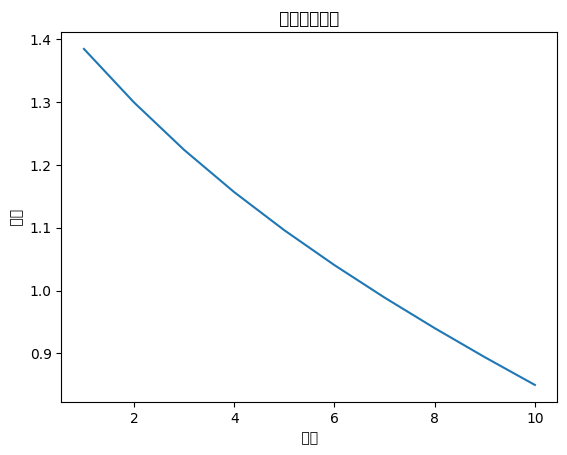

In [35]:
# 训练 cbow 类
learning_rate = 0.001 # 设置学习速率
epochs = 1000 # 设置训练轮次
criterion = nn.CrossEntropyLoss()  # 定义交叉熵损失函数
import torch.optim as optim # 导入随机梯度下降优化器
optimizer = optim.SGD(cbow_model.parameters(), lr=learning_rate)  
# 开始训练循环
loss_values = []  # 用于存储每轮的平均损失值
for epoch in range(epochs):
    loss_sum = 0 # 初始化损失值
    for target, context_words in cbow_data:
        # 将上下文词转换为 One-Hot 向量并堆叠
        X = torch.stack([one_hot_encoding(word, word_to_idx) for word in context_words]).float() 
        print(X.shape,"_______")
        # 将目标词转换为索引值
        y_true = torch.tensor([word_to_idx[target]], dtype=torch.long) 
        y_pred = cbow_model(X)  # 计算预测值
        print(y_pred.shape, y_true.shape)
        loss = criterion(y_pred, y_true)  # 计算损失
        loss_sum += loss.item() # 累积损失
        optimizer.zero_grad()  # 清空梯度
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
    if (epoch+1) % 100 == 0: # 输出每 100 轮的损失，并记录损失
      print(f"Epoch: {epoch+1}, Loss: {loss_sum/len(cbow_data)}")
      loss_values.append(loss_sum / len(cbow_data))
# 绘制训练损失曲线
import matplotlib.pyplot as plt # 导入 matplotlib
# 绘制二维词向量图
plt.rcParams["font.family"]=['SimHei'] # 用来设定字体样式
plt.rcParams['font.sans-serif']=['SimHei'] # 用来设定无衬线字体样式
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
plt.plot(range(1, epochs//100 + 1), loss_values) # 绘图
plt.title(' 训练损失曲线 ') # 图题
plt.xlabel(' 轮次 ') # X 轴 Label
plt.ylabel(' 损失 ') # Y 轴 Label
plt.show() # 显示图

In [18]:
# 输出 cbow 习得的词嵌入
print("CBOW 词嵌入：")
for word, idx in word_to_idx.items(): # 输出每个词的嵌入向量
    print(f"{word}: {cbow_model.input_to_hidden.weight[:,idx].detach().numpy()}")

CBOW 词嵌入：
Teacher: [ 0.96269375 -0.19590575]
Boss: [ 1.6468875  -0.12993261]
Student: [-0.1371219 -1.1803839]
Kage: [ 0.02967809 -0.61996543]
Xiaoxue: [ 0.09207372 -0.06454386]
Niuzong: [0.12451312 0.1310945 ]
Mazong: [0.268875   0.28100872]
Xiaobing: [ 0.02825192 -0.01834969]
is: [-0.7315529  0.9738903]


findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
/root/miniconda3/envs/py312/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21521 (\N{CJK UNIFIED IDEOGRAPH-5411}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/py312/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/py312/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32500 (\N{CJK UNIFIED IDEOGRAPH-7EF4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/py312/lib/pytho

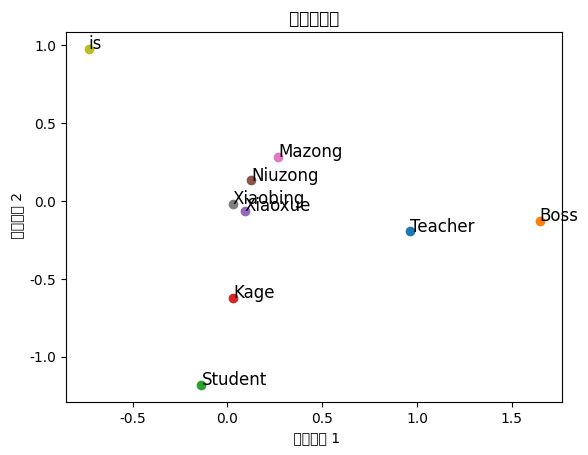

In [19]:
fig, ax = plt.subplots() 
for word, idx in word_to_idx.items():
    # 获取每个单词的嵌入向量
    vec = cbow_model.input_to_hidden.weight[:,idx].detach().numpy() 
    ax.scatter(vec[0], vec[1]) # 在图中绘制嵌入向量的点
    ax.annotate(word, (vec[0], vec[1]), fontsize=12) # 点旁添加单词标签
plt.title(' 二维词嵌入 ') # 图题
plt.xlabel(' 向量维度 1') # X 轴 Label
plt.ylabel(' 向量维度 2') # Y 轴 Label
plt.show() # 显示图